# Movie Box Office Analysis

In [1]:
from config import api_key
import requests
from scipy.stats import linregress
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# We only analyze 500 titles with highest worldwide box office between Years 2010-2016, due to the API call limit.
df = pd.read_csv("movie_data.csv", nrows=500)
# Change "Gross" to "Box Office" as the standard term.
df.columns = df.columns.str.replace("Gross", "Box Office")
df.head()

,Movie,Month,Day,Release Year,Budget ($m),Domestic Box Office ($m),Worldwide Box Office ($m),Foreign Box Office ($m)
0,Star Wars Ep. VII: The Force Awakens,Dec,18,2015,306.0,936.662225,2058.662225,1122.000000
1,Jurassic World,Jun,12,2015,215.0,652.198010,1670.328025,1018.130015
2,The Avengers,May,4,2012,225.0,623.279547,1519.479547,896.200000
3,Furious 7,Apr,3,2015,190.0,351.032910,1514.019071,1162.986161
4,Avengers: Age of Ultron,May,1,2015,250.0,459.005868,1404.705868,945.700000


In [3]:
base = f"http://www.omdbapi.com/?apikey={api_key}&r=json&t="
urls = [(base + row) for row in df["Movie"]]

In [4]:
responses = [requests.get(url).json() for url in urls]

In [5]:
len(responses)

500

In [6]:
# Some movies got no match from API due to spelling differences in the title.
rows_to_remove = []
for response in responses:
    if response["Response"] == "False":
        rows_to_remove.append(responses.index(response))
        responses.remove(response)

In [7]:
# Final number of movies to analyze is 475.
print(rows_to_remove)
print(len(responses))

[0, 4, 21, 30, 88, 122, 128, 145, 147, 156, 197, 247, 248, 249, 258, 264, 283, 290, 292, 326, 340, 366, 405, 422, 437]
475


In [8]:
# Remove the 25 rows with no match.
df = df.drop(rows_to_remove).reset_index()
del df["index"]
df.head()

,Movie,Month,Day,Release Year,Budget ($m),Domestic Box Office ($m),Worldwide Box Office ($m),Foreign Box Office ($m)
0,Jurassic World,Jun,12,2015,215.0,652.198010,1670.328025,1018.130015
1,The Avengers,May,4,2012,225.0,623.279547,1519.479547,896.200000
2,Furious 7,Apr,3,2015,190.0,351.032910,1514.019071,1162.986161
3,Harry Potter and the Deathly Hallows: Part II,Jul,15,2011,125.0,381.011219,1341.511219,960.500000
4,Frozen,Nov,22,2013,150.0,400.738009,1274.234980,873.496971


## Audience review vs. critic review vs. worldwide box office

* Q: Do audience (IMDb rating) and critics (Metascore) have different tastes on movies? Does good/bad review affect the (worldwide) box office of a movie?

* A: The audience (blue circles) generally tend to give a movie higher score than the critics (red circles) do. Also, the audience's scores concentrate considerably between 0.5 to 0.9, whereas the critics' scores are much more wide spread across all, likely because the critics can get more technical and show stronger opinions.
* As for how reviews affect box office, There are plenty of movies grossing low box office regardless of their scores. For the rest that did make more box office (more than 400m dollors), it seems audience's good reviews helped slightly.

In [9]:
rating_df = df[["Movie", "Worldwide Box Office ($m)"]].copy()
rating_df["IMDb Rating"] = [responses[_]["imdbRating"] for _ in range(len(responses))]
rating_df["Metascore"] = [responses[_]["Metascore"] for _ in range(len(responses))]

In [10]:
# The reviews are strings when imported.
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 4 columns):
Movie                        475 non-null object
Worldwide Box Office ($m)    475 non-null float64
IMDb Rating                  475 non-null object
Metascore                    475 non-null object
dtypes: float64(1), object(3)
memory usage: 14.9+ KB


In [11]:
# Also, there are missing values in "Metascore".
rating_df["Metascore"].value_counts()

57     14
59     13
56     13
39     13
52     13
55     13
51     12
53     12
58     12
66     12
60     12
N/A    11
40     11
65     10
72     10
41     10
75     10
74     10
68     10
62      9
34      9
37      8
63      8
50      8
69      8
47      8
44      8
67      7
46      7
43      7
       ..
78      4
88      3
90      3
73      3
70      3
27      3
83      3
84      3
31      3
95      2
22      2
21      2
86      2
96      2
25      2
23      2
80      2
24      2
93      1
94      1
29      1
26      1
20      1
89      1
87      1
82      1
13      1
18      1
19      1
92      1
Name: Metascore, Length: 79, dtype: int64

In [12]:
# Remove missing values.
rating_df = rating_df[rating_df["Metascore"] != "N/A"]
# Change data type to numeric.
rating_df["IMDb Rating"] = rating_df["IMDb Rating"].astype(float)
rating_df["Metascore"] = rating_df["Metascore"].astype(int)
# Normalize the two ratings.
rating_df["IMDb Rating (Normalized)"] = (rating_df["IMDb Rating"] - rating_df["IMDb Rating"].min())/\
                                        (rating_df["IMDb Rating"].max() - rating_df["IMDb Rating"].min())
rating_df["Metascore (Normalized)"] = (rating_df["Metascore"] - rating_df["Metascore"].min())/\
                                        (rating_df["Metascore"].max() - rating_df["Metascore"].min())

In [13]:
rating_df.head()

,Movie,Worldwide Box Office ($m),IMDb Rating,Metascore,IMDb Rating (Normalized),Metascore (Normalized)
0,Jurassic World,1670.328025,7.0,59,0.750000,0.554217
1,The Avengers,1519.479547,8.1,69,0.902778,0.674699
2,Furious 7,1514.019071,7.2,67,0.777778,0.650602
3,Harry Potter and the Deathly Hallows: Part II,1341.511219,7.4,66,0.805556,0.638554
4,Frozen,1274.234980,7.5,74,0.819444,0.734940


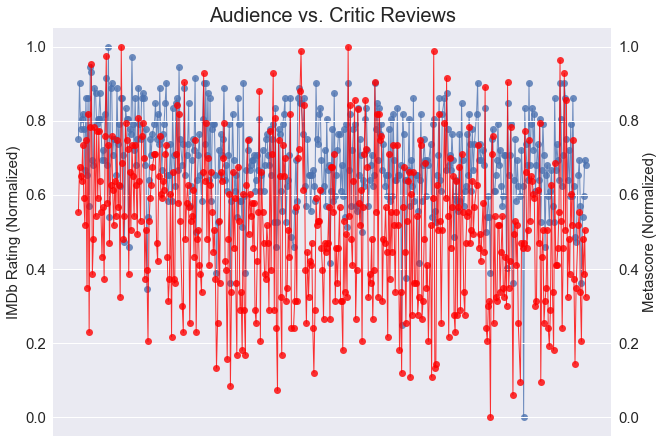

In [14]:
plt.style.use("seaborn")
fig, ax1 = plt.subplots(figsize=(10,7.5))
ax2 = ax1.twinx()
ax1.plot(rating_df["IMDb Rating (Normalized)"], marker="o", alpha=.8, lw=1)
ax2.plot(rating_df["Metascore (Normalized)"], c="r", marker="o", alpha=.8, lw=1)
plt.title("Audience vs. Critic Reviews", size=20)
ax1.set_ylabel("IMDb Rating (Normalized)", size=15)
ax2.set_ylabel("Metascore (Normalized)", size=15)
ax1.set_xticks([])
ax1.yaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
plt.savefig("Plot1.1.png", bbox_inches="tight")
plt.show()

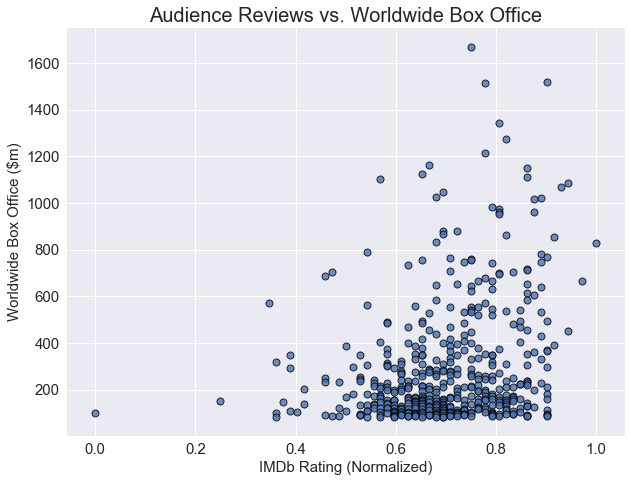

In [15]:
plt.figure(figsize=(10,7.5))
plt.scatter(rating_df["IMDb Rating (Normalized)"], rating_df["Worldwide Box Office ($m)"], alpha=.8, lw=1, edgecolors="k")
plt.title("Audience Reviews vs. Worldwide Box Office", size=20)
plt.xlabel("IMDb Rating (Normalized)", size=15)
plt.ylabel("Worldwide Box Office ($m)", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("Plot1.2.png", bbox_inches="tight")
plt.show()

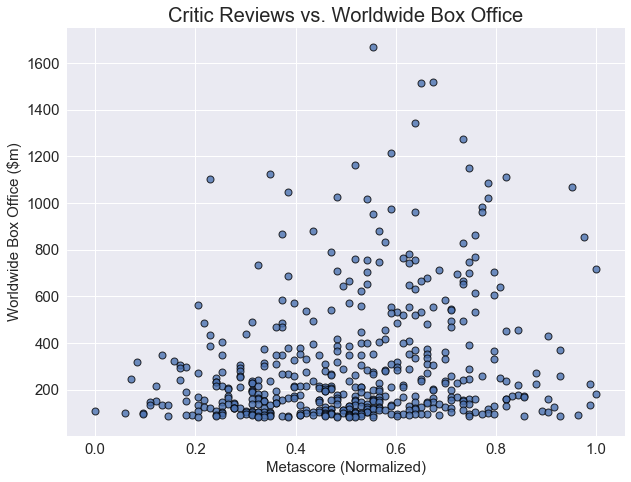

In [16]:
plt.figure(figsize=(10,7.5))
plt.scatter(rating_df["Metascore (Normalized)"], rating_df["Worldwide Box Office ($m)"], alpha=.8, lw=1, edgecolors="k")
plt.title("Critic Reviews vs. Worldwide Box Office", size=20)
plt.xlabel("Metascore (Normalized)", size=15)
plt.ylabel("Worldwide Box Office ($m)", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("Plot1.3.png", bbox_inches="tight")
plt.show()

## Genre vs. box office

* Q: What are the most/least favorable genres based on box office? What are the similarities and differences between domestic and foreign markets?

* A: The 5 most/least favorable genres turn to be very similar between domestic and foreign market. It's the era of globalization and sure movie-goers around the world can all enjoy sci-fi, action and animation movies, while documentary and horror movies are less popular. It's interesting to see that musical movies are least popular domestically, whereas they're quite popular (just next to fantasy movies) in the foreign market. The American people need to cheer up!

In [17]:
genre_df = df[["Movie", "Domestic Box Office ($m)", "Foreign Box Office ($m)"]].copy()
genre_df["Genre Count"] = [len(responses[_]["Genre"].split(", ")) for _ in range(len(responses))]

In [18]:
# Most movies have 3 genres, some 2, some 1.
genre_df["Genre Count"].value_counts()

3    353
2     93
1     29
Name: Genre Count, dtype: int64

In [19]:
# Create 3 data frames, add genres, and concatenate them.
genre_df1 = genre_df.copy()
genre_df2 = genre_df.copy()
genre_df3 = genre_df.copy()
genre_df1["Genre"] = [responses[_]["Genre"].split(", ")[0] for _ in range(len(responses))]

In [20]:
for _ in range(len(responses)):
    try:
        genre_df2.loc[_,"Genre"] = responses[_]["Genre"].split(", ")[1]
    except:
        genre_df2.loc[_,"Genre"] = None
genre_df12 = pd.concat([genre_df1, genre_df2])

In [21]:
for _ in range(len(responses)):
    try:
        genre_df3.loc[_,"Genre"] = responses[_]["Genre"].split(", ")[2]
    except:
        genre_df3.loc[_,"Genre"] = None
genre_df123 = pd.concat([genre_df12, genre_df3])

In [22]:
# Remove the rows with no genre.
genre_df123 = genre_df123.dropna(how="any").reset_index()
del genre_df123["index"]
genre_df123.tail()

,Movie,Domestic Box Office ($m),Foreign Box Office ($m),Genre Count,Genre
1269,J. Edgar,37.306030,47.300000,3,Drama
1270,Priest,29.136626,55.017400,3,Horror
1271,Piranha 3D,25.003155,58.657005,3,Thriller
1272,Edge of Darkness,43.313890,39.498566,3,Mystery
1273,Act of Valor,70.012847,12.484188,3,Drama


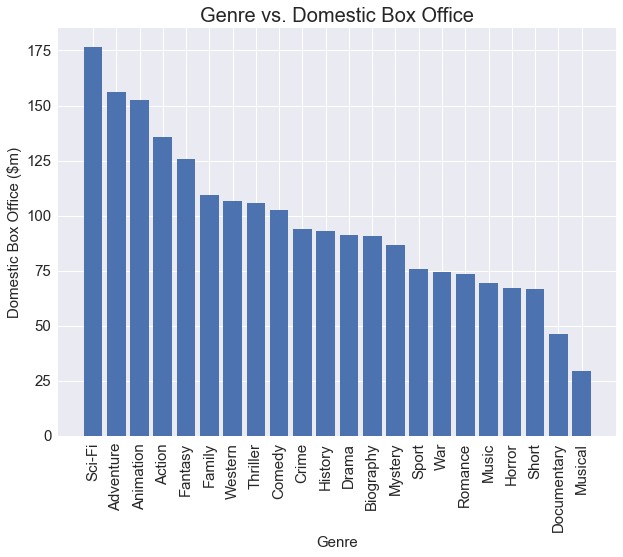

In [23]:
domestic_by_genre = genre_df123.groupby("Genre")["Domestic Box Office ($m)"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,7.5))
plt.bar(range(len(domestic_by_genre)), domestic_by_genre, align="center")
plt.title("Genre vs. Domestic Box Office", size=20)
plt.xlabel("Genre", size=15)
plt.ylabel("Domestic Box Office ($m)", size=15)
plt.xticks(range(len(domestic_by_genre)), domestic_by_genre.index, rotation="vertical", size=15)
plt.yticks(size=15)
plt.savefig("Plot2.1.png", bbox_inches="tight")
plt.show()

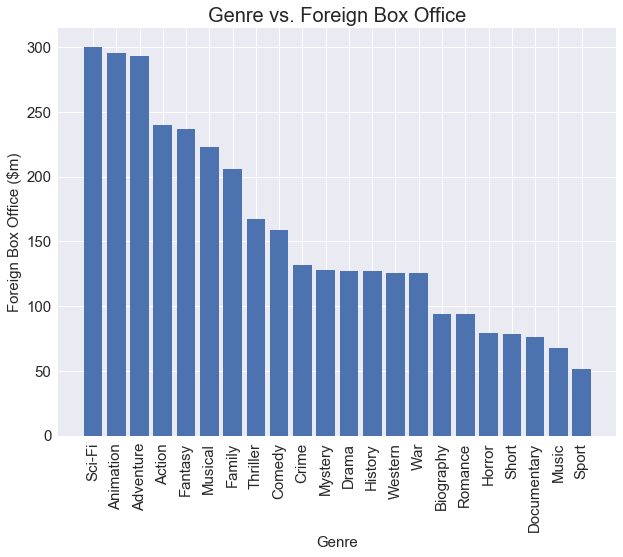

In [24]:
foreign_by_genre = genre_df123.groupby("Genre")["Foreign Box Office ($m)"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,7.5))
plt.bar(range(len(foreign_by_genre)), foreign_by_genre, align="center")
plt.title("Genre vs. Foreign Box Office", size=20)
plt.xlabel("Genre", size=15)
plt.ylabel("Foreign Box Office ($m)", size=15)
plt.xticks(range(len(foreign_by_genre)), foreign_by_genre.index, rotation="vertical", size=15)
plt.yticks(size=15)
plt.savefig("Plot2.2.png", bbox_inches="tight")
plt.show()

## Production studio vs. box office

* Q: What are the market shares by studio? How is the domestic market compared to the foreign?

* A: Disney is dominating worldwide. It even has a slightly better performance in the foreign market. I guess everybody has his inner child. This is because of course Disney is so good at making animation, family and adventure movies, which are all among the top genres. The rest of the market is divided by other major studios quite evenly. Independent studios make great movies, but when it comes to money, the blockbusters still rule.

In [25]:
studio_df = df[["Movie", "Domestic Box Office ($m)", "Foreign Box Office ($m)"]].copy()
for _ in range(len(responses)):
    try:
        studio_df.loc[_,"Production"] = responses[_]["Production"].split(" ")[0].split("/")[0]
    except:
        studio_df.loc[_,"Production"] = None

In [26]:
studio_df["Production"].value_counts()

Warner          77
Universal       62
20th            58
Sony            55
Paramount       50
Walt            40
Lionsgate       25
The             13
Summit           9
Columbia         8
Relativity       7
Focus            6
Fox              5
DreamWorks       5
Screen           4
New              4
N                4
FilmDistrict     3
MGM              3
Disney           3
TriStar          3
Twentieth        3
Dreamworks       3
CBS              2
Open             2
Ombra            1
Working          1
Buena            1
Bad              1
Anchor           1
Smokehouse       1
Edko             1
Radius-TWC       1
Netflix          1
Gold             1
Disneynature     1
ITV              1
Orion            1
Touchstone       1
Block            1
IMAX             1
RatPac-Dune      1
Name: Production, dtype: int64

In [27]:
# Messy data in "Production". Tidy them and put in "Studio".
for _ in range(len(responses)):
    if studio_df.loc[_,"Production"] == "Warner":
        studio_df.loc[_,"Studio"] = "Warner Bros."
    elif studio_df.loc[_,"Production"] in ["20th", "Twentieth"]:
        studio_df.loc[_,"Studio"] = "20th Century Fox"
    elif studio_df.loc[_,"Production"] == "Walt":
        studio_df.loc[_,"Studio"] = "Disney"
    elif studio_df.loc[_,"Production"] in ["Paramount", "Universal", "Sony", "Lionsgate", "Disney"]:
        studio_df.loc[_,"Studio"] = studio_df.loc[_,"Production"]
    else:
        studio_df.loc[_,"Studio"] = "Other"

In [28]:
studio_df.head()

,Movie,Domestic Box Office ($m),Foreign Box Office ($m),Production,Studio
0,Jurassic World,652.198010,1018.130015,Universal,Universal
1,The Avengers,623.279547,896.200000,Walt,Disney
2,Furious 7,351.032910,1162.986161,Universal,Universal
3,Harry Potter and the Deathly Hallows: Part II,381.011219,960.500000,Walt,Disney
4,Frozen,400.738009,873.496971,Walt,Disney


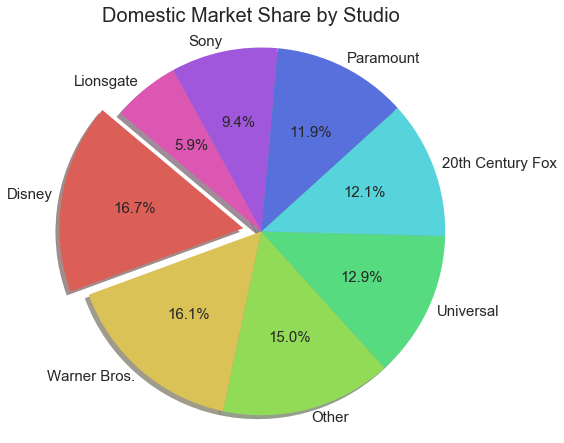

In [29]:
domestic_by_studio = studio_df.groupby("Studio")["Domestic Box Office ($m)"].sum().sort_values(ascending=False)
plt.figure(figsize=(7.5,7.5))
patches, texts, autotexts = plt.pie(domestic_by_studio, labels=domestic_by_studio.index, explode=(0.1,0,0,0,0,0,0,0), 
                                    colors=sns.color_palette("hls", 8), autopct="%1.1f%%", shadow=True, labeldistance=1.05, 
                                    startangle=140)
plt.title("Domestic Market Share by Studio", size=20)
for text in texts:
    text.set_fontsize(15)
for autotext in autotexts:
    autotext.set_fontsize(15)
plt.axis("equal")
plt.savefig("Plot3.1.png", bbox_inches="tight")
plt.show()

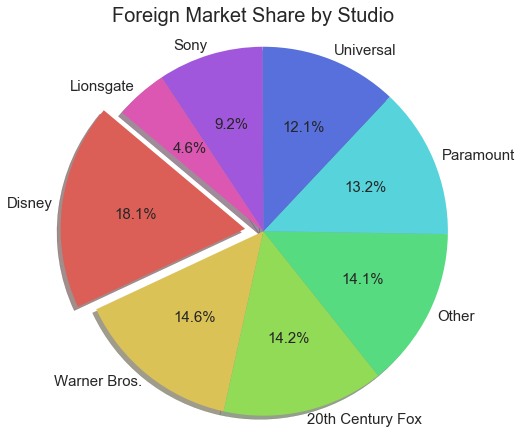

In [30]:
foreign_by_studio = studio_df.groupby("Studio")["Foreign Box Office ($m)"].sum().sort_values(ascending=False)
plt.figure(figsize=(7.5,7.5))
patches, texts, autotexts = plt.pie(foreign_by_studio, labels=foreign_by_studio.index, explode=(0.1,0,0,0,0,0,0,0), 
                                    colors=sns.color_palette("hls", 8), autopct="%1.1f%%", shadow=True, labeldistance=1.05,
                                    startangle=140)
plt.title("Foreign Market Share by Studio", size=20)
for text in texts:
    text.set_fontsize(15)
for autotext in autotexts:
    autotext.set_fontsize(15)
plt.axis("equal")
plt.savefig("Plot3.2.png", bbox_inches="tight")
plt.show()

## Budget vs. worldwide box office vs. MPAA rating

* Q: What's the correlation between a movie's budget and its (worldwide) box office? Which MPAA rating is most/least profitable?

* A: These days an original and well-executed idea can really pay. Generally the higher the budget, the better the box office. But we all hear about some low-budget movie made a tons of money, or some supposedly A-lister is leading to the bankruptcy of a studio.
* Looking at the ratings, the market consists mostly of PG and PG-13 movies. These movies seem to find a good balance between artistic expression and commercial performance. You don't see too many G movies any more. But since they are usually family-oriented, their profitability is actually the highest (1 dollor of budget outputs nearly 5 of box office, with 71% explained by the regression model). On the other hand, the majority of R movies are low-budget and low in box office. Except for a small portion that made to commercial success, they are as whole the least profitable.

In [31]:
rated_df = df[["Movie", "Budget ($m)", "Worldwide Box Office ($m)"]].copy()
rated_df["Rated"] = [responses[_]["Rated"] for _ in range(len(responses))]

In [32]:
# Some unexpected values in "Rated".
rated_df["Rated"].value_counts()

PG-13        220
R            137
PG            96
G             11
N/A            5
NOT RATED      3
TV-14          2
TV-G           1
Name: Rated, dtype: int64

In [33]:
# Remove them.
rated_df = rated_df[(rated_df["Rated"] != "N/A") & (rated_df["Rated"] != "NOT RATED") & 
                    (rated_df["Rated"] != "TV-14") & (rated_df["Rated"] != "TV-G")]
rated_df.head()

,Movie,Budget ($m),Worldwide Box Office ($m),Rated
0,Jurassic World,215.0,1670.328025,PG-13
1,The Avengers,225.0,1519.479547,PG-13
2,Furious 7,190.0,1514.019071,PG-13
3,Harry Potter and the Deathly Hallows: Part II,125.0,1341.511219,PG-13
4,Frozen,150.0,1274.234980,PG


In [34]:
rated_df1 = rated_df[rated_df["Rated"] == "G"]
s1, i1, r1, _, _ = linregress(rated_df1["Budget ($m)"], rated_df1["Worldwide Box Office ($m)"])
rated_df2 = rated_df[rated_df["Rated"] == "R"]
s2, i2, r2, _, _ = linregress(rated_df2["Budget ($m)"], rated_df2["Worldwide Box Office ($m)"])

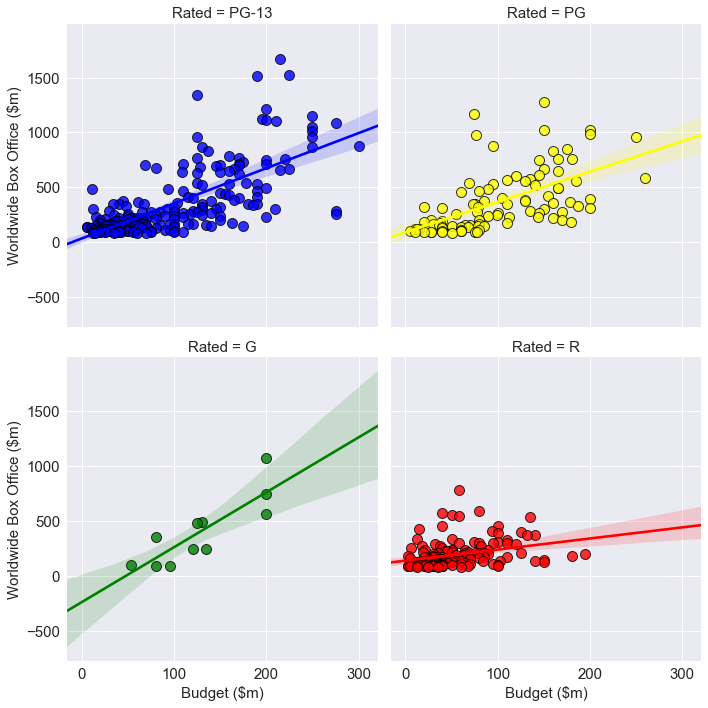

In [36]:
rated = ["G","PG","PG-13","R"]
colors = ["g","yellow","b","r"]
sns.lmplot(x="Budget ($m)", y="Worldwide Box Office ($m)", data=rated_df, hue="Rated", palette={i:j for i,j in zip(rated,colors)}, 
col="Rated", col_wrap=2, scatter_kws={"alpha": .8, "s": 100, "lw": 1, "edgecolors": "k"}, size=5, aspect=1, legend=False)
sns.set(rc={"axes.labelsize": 15, "axes.titlesize": 15, "xtick.labelsize": 15, "ytick.labelsize": 15})
plt.savefig("Plot4.1.png", bbox_inches="tight")
plt.show()

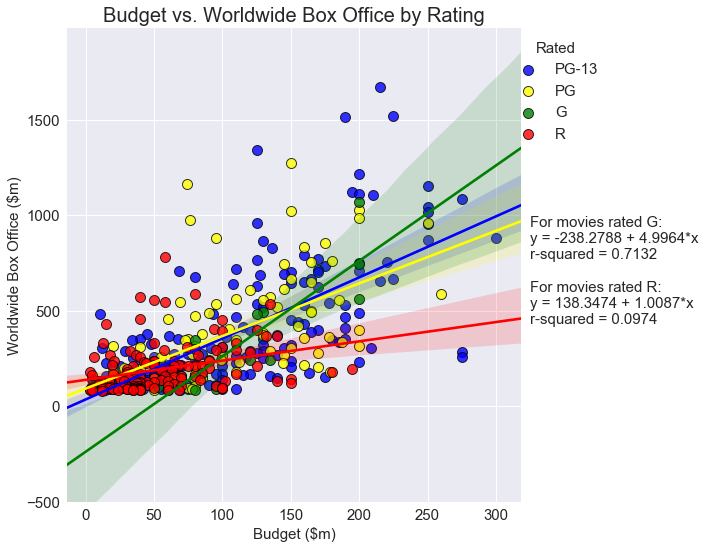

In [38]:
sns.lmplot(x="Budget ($m)", y="Worldwide Box Office ($m)", data=rated_df, hue="Rated", palette={i:j for i,j in zip(rated,colors)}, 
           scatter_kws={"alpha": .8, "s": 100, "lw": 1, "edgecolors": "k"}, size=7.5, aspect=1, legend=False)
plt.title("Budget vs. Worldwide Box Office by Rating", size=20)
plt.xlabel("Budget ($m)", size=15)
plt.ylabel("Worldwide Box Office ($m)", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(ymin=-500)
lgd = plt.legend(fontsize=15, bbox_to_anchor=(1.2, 1))
lgd.set_title("Rated", prop={"size": 15})
plt.text(325, 1000, f"""For movies rated G:\ny = {round(i1,4)} + {round(s1,4)}*x\nr-squared = {round(r1**2,4)}\n
For movies rated R:\ny = {round(i2,4)} + {round(s2,4)}*x\nr-squared = {round(r2**2,4)}""", va="top", size=15)
plt.savefig("Plot4.2.png", bbox_inches="tight")
plt.show()